In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data Examination

In [2]:
#laod the datasets into dataframe
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,No of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Check data shape
df.shape

(144, 2)

In [4]:
# Find total missing values in the entire dataset
total_missing = df.isnull().sum().sum()
print("Total missing values:", total_missing)

Total missing values: 0


In [5]:
# Total count of duplicate rows
total_duplicates = df.duplicated().sum()
print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 0


In [6]:
# Summary statistics
summary = df.describe()  # Descriptive statistics for numerical data
summary

,No of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Data Preparation

In [7]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df = df.asfreq('MS')  # Setting the frequency to Month Start (MS)

df.head()

,No of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Time Series Plot

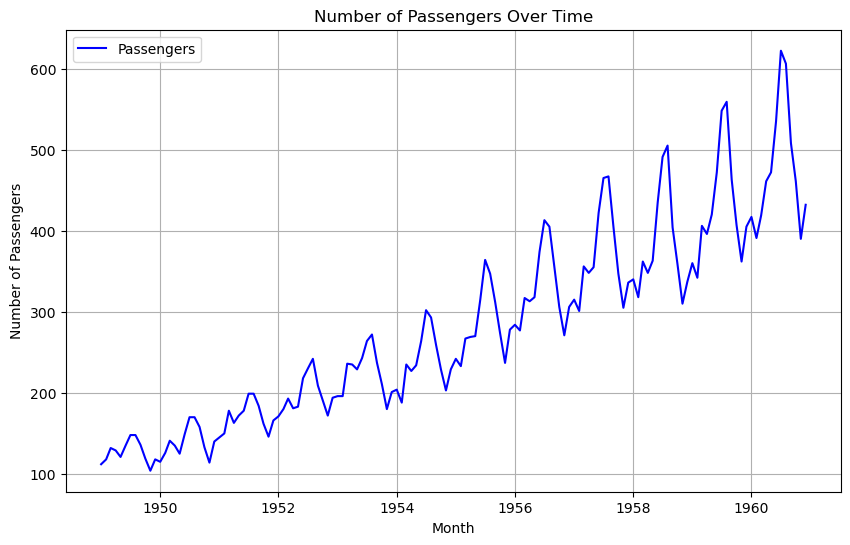

In [8]:
# Plotting the time series data as a line chart
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(df['No of Passengers'], linestyle='-', color='b', label='Passengers')  # Line plot with markers
plt.title('Number of Passengers Over Time')  # Title of the chart
plt.xlabel('Month')  # Label for the x-axis
plt.ylabel('Number of Passengers')  # Label for the y-axis
plt.grid(True)  # Add grid lines for better readability
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot

## Decompose

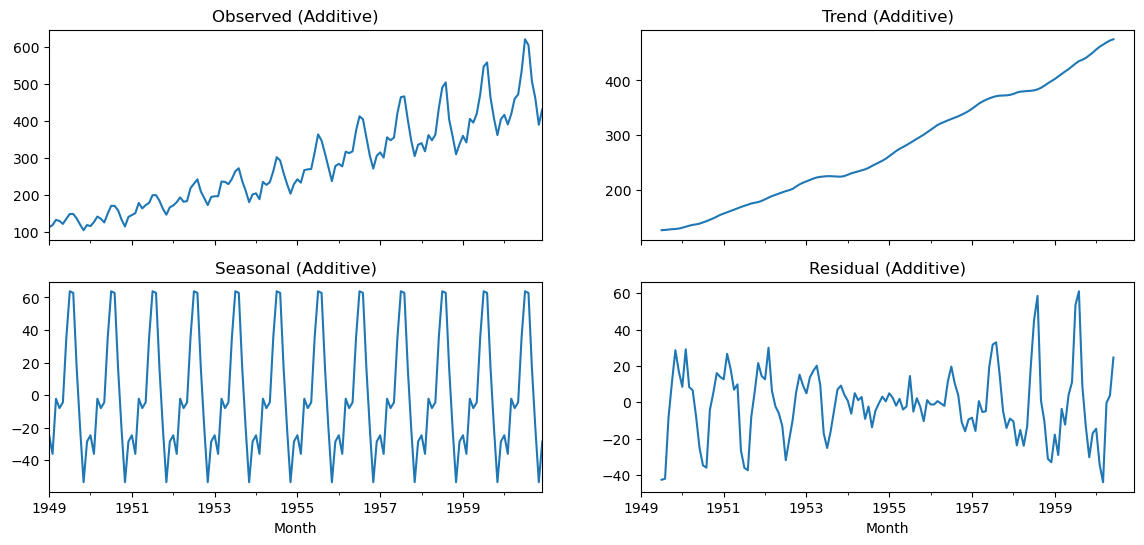

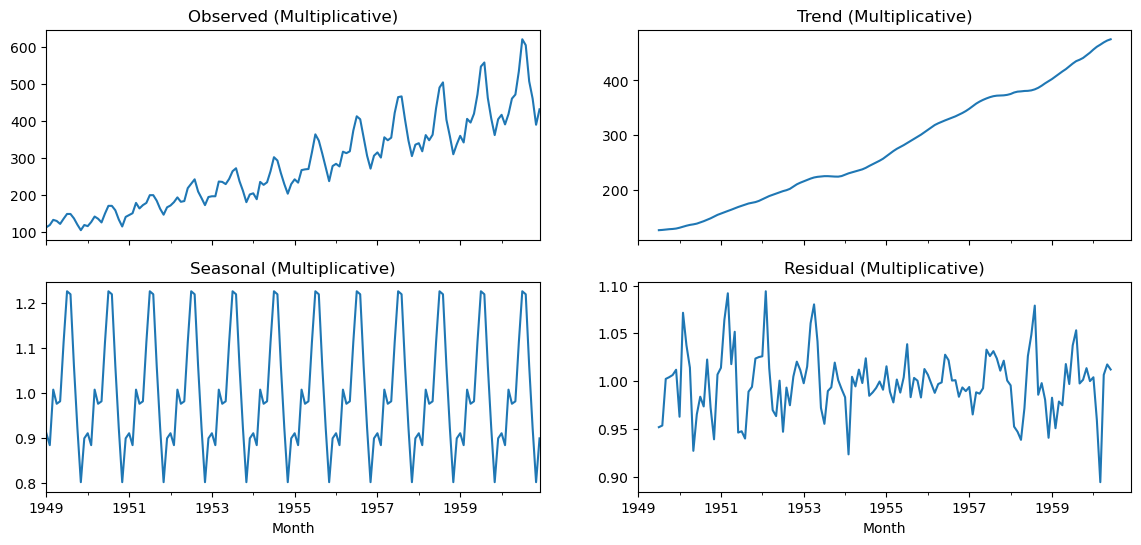

In [9]:
# Decomposition with additive model
result_additive = seasonal_decompose(df['No of Passengers'], model='additive')  

# Decomposition with multiplicative model
result_multiplicative = seasonal_decompose(df['No of Passengers'], model='multiplicative')  

# Create a 1x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

# Plot additive decomposition
result_additive.observed.plot(ax=ax1, title='Observed (Additive)')
result_additive.trend.plot(ax=ax2, title='Trend (Additive)')
result_additive.seasonal.plot(ax=ax3, title='Seasonal (Additive)')
result_additive.resid.plot(ax=ax4, title='Residual (Additive)')

plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

# Plot multiplicative decomposition
result_multiplicative.observed.plot(ax=ax1, title='Observed (Multiplicative)')
result_multiplicative.trend.plot(ax=ax2, title='Trend (Multiplicative)')
result_multiplicative.seasonal.plot(ax=ax3, title='Seasonal (Multiplicative)')
result_multiplicative.resid.plot(ax=ax4, title='Residual (Multiplicative)')

plt.show()

## Stationarity Test

In [10]:
# Perform the ADF test
adf_result = adfuller(df['No of Passengers'])

# Extract the ADF statistic, p-value, and critical values
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Determine if the series is stationary based on the p-value and critical values
is_stationary = False  # Default assumption
significance_level = 0.05  # Commonly used significance level

# Check the p-value against the significance level
if p_value < significance_level:
    is_stationary = True

# Check if the ADF statistic is less than the critical value at 5%
if adf_statistic < critical_values['5%']:
    is_stationary = True

# Print the results
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

if is_stationary:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
The time series is not stationary.


## Modelling & Forecasts

## Moving Average

In [11]:
# Define the range of window sizes to test
window_range = list(range(2, 21))  # Testing window sizes from 2 to 20
mse_values = []  # List to store MSE for each window size

# Loop over window sizes
for window_size in window_range:
    # Apply Simple Moving Average (SMA)
    df['SMA'] = df['No of Passengers'].rolling(window=window_size).mean()

    # Calculate errors
    errors = df['No of Passengers'] - df['SMA']

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(errors.dropna() ** 2)  # Drop NaN values from beginning
    mse_values.append(mse)  # Store MSE value

# Find the optimal window size with the minimum MSE
optimal_window_size = window_range[np.argmin(mse_values)]
print("Optimal Window Size:", optimal_window_size)

Optimal Window Size: 2


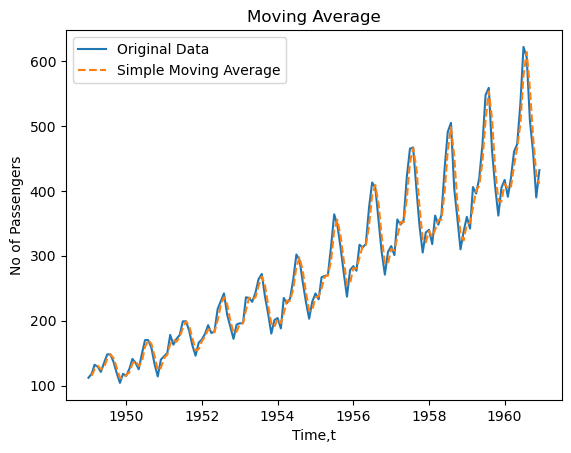

MAD for MA: 40.042
MAPE for MA: 12.39%
MSE for MA: 2995.1646


In [12]:
# Apply a simple moving average with a specified window
window_size = 2
df['SMA'] = df['No of Passengers'].rolling(window=window_size).mean()

# Plot original data and the simple moving average
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['SMA'], label='Simple Moving Average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Calculate errors
errors_ma = df['No of Passengers'] - df['SMA']

# Performance metrics
# Calculate Mean Absolute Deviation (MAD)
MAD_MA = np.mean(np.abs(errors))

# Calculate Mean Absolute Percentage Error (MAPE)
# Avoid division by zero with a condition
MAPE_MA = np.mean(np.abs(errors) / df['No of Passengers']) * 100

# Calculate Mean Squared Error (MSE)
MSE_MA = np.mean(errors ** 2)

print("MAD for MA:", round(MAD_MA, 4))
print("MAPE for MA:", f"{round(MAPE_MA, 2)}%")
print("MSE for MA:", round(MSE_MA, 4))

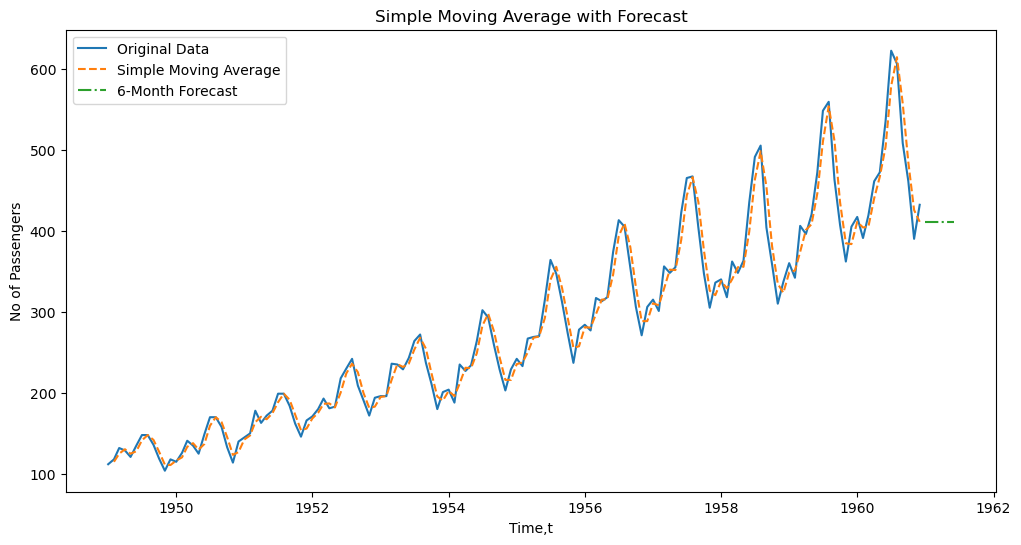

6-Month Forecast:
       Month  Forecast
0 1961-01-01     411.0
1 1961-02-01     411.0
2 1961-03-01     411.0
3 1961-04-01     411.0
4 1961-05-01     411.0
5 1961-06-01     411.0


In [13]:
# Forecasting 6 months ahead based on the last known SMA
forecast_steps = 6  # Number of months to forecast
last_sma_value = df['SMA'].iloc[-1]  # Last known SMA value

# Create forecast dates
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]  # Skip the last known point

# Generate forecast by extending the SMA
forecast = [last_sma_value] * forecast_steps  # Naïve extension

# Plot the original data, SMA, and the 6-month forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['SMA'], label='Simple Moving Average', linestyle='--')
plt.plot(forecast_dates, forecast, label='6-Month Forecast', linestyle='-.')
plt.legend()
plt.title('Simple Moving Average with Forecast')
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Create a DataFrame to list the forecasted values and round them
forecast_MA = pd.DataFrame({'Month': forecast_dates,'Forecast': pd.Series(forecast).round()})

# Display the 6-month forecast with rounded values
print("6-Month Forecast:")
print(forecast_MA)


## Simple Exponential Smoothing

Optimal Alpha: 0.995


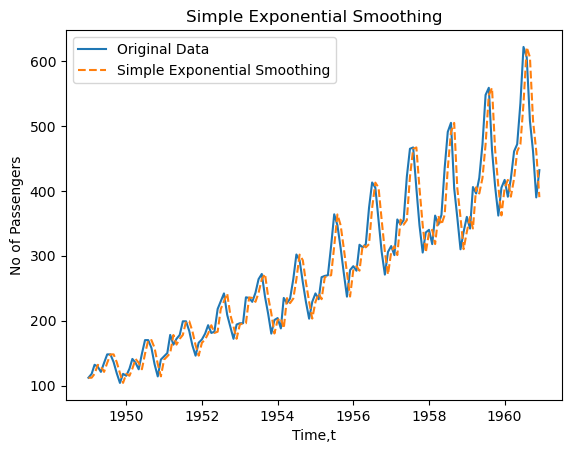

MAD for SES: 25.7159
MAPE for SES: 8.97%
MSE for SES: 1131.9677


In [14]:
# Applying simple exponential smoothing
model = SimpleExpSmoothing(df['No of Passengers'])
fit = model.fit()  # smoothing_level determines how much weight to give recent data

df['SES'] = fit.fittedvalues

# Optimal smoothing level used (optimal alpha) for SES
optimal_alpha = fit.model.params['smoothing_level']
print("Optimal Alpha:", optimal_alpha)

# Plotting original data and simple exponential smoothing
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['SES'], label='Simple Exponential Smoothing', linestyle='--')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Performance metrics
# Calculate errors for SES
errors_ses = df['No of Passengers'] - df['SES']

# Mean Absolute Deviation (MAD) for SES
MAD_SES = np.mean(np.abs(errors_ses))

# Mean Absolute Percentage Error (MAPE) for SES
MAPE_SES = np.mean(np.abs(errors_ses) / df['No of Passengers']) * 100

# Mean Squared Error (MSE) for SES
MSE_SES = np.mean(errors_ses ** 2)

print("MAD for SES:", round(MAD_SES, 4))
print("MAPE for SES:", f"{round(MAPE_SES, 2)}%")
print("MSE for SES:", round(MSE_SES, 4))


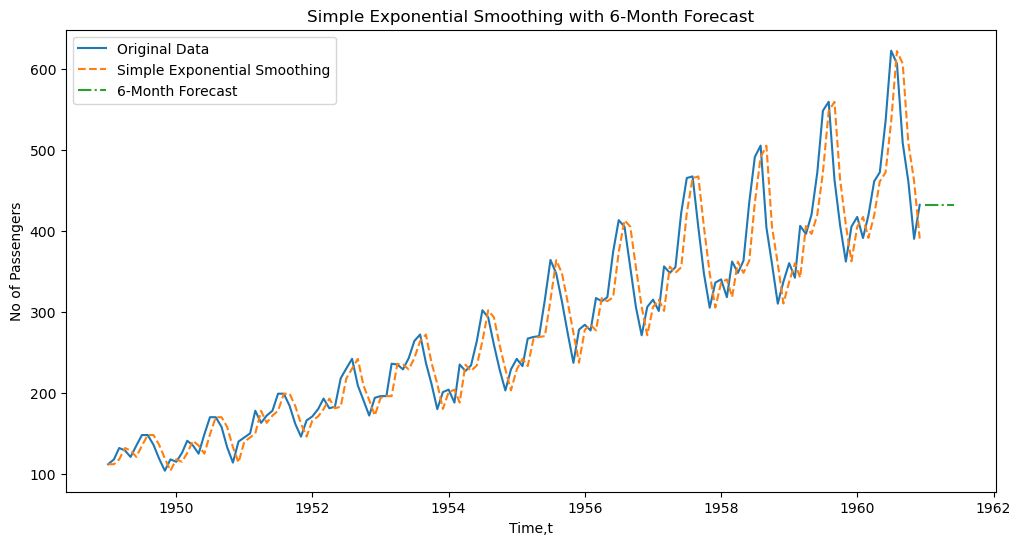

6-Month Forecast:
            Forecast
1961-01-01     432.0
1961-02-01     432.0
1961-03-01     432.0
1961-04-01     432.0
1961-05-01     432.0
1961-06-01     432.0


In [15]:
# Forecast 6 months ahead with SES
forecast_steps = 6  # Number of months to forecast
forecast = fit.forecast(forecast_steps)

# Create forecast dates for the next 6 months
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]  # Excluding the last known point

# Plot the original data, SES fitted values, and the 6-month forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(fit.fittedvalues, label='Simple Exponential Smoothing', linestyle='--')
plt.plot(forecast_dates, forecast, label='6-Month Forecast', linestyle='-.')
plt.legend()
plt.title('Simple Exponential Smoothing with 6-Month Forecast')
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Ensure forecast is a pandas Series before rounding
forecast_series = pd.Series(forecast, index=forecast_dates)

# Create a DataFrame with the forecasted values and round them
forecast_SES = pd.DataFrame({
    'Forecast': forecast_series.round()})

# Display the 6-month forecasted values
print("6-Month Forecast:")
print(forecast_SES)


## Holt's Model

Optimal Alpha (smoothing level): 0.995
Optimal Beta (smoothing slope): None


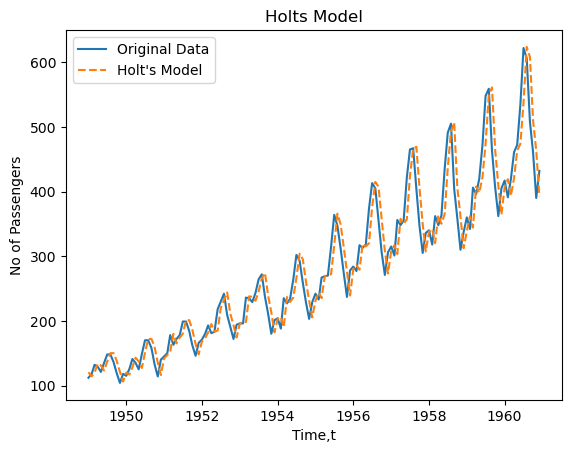

MAD for Holt: 25.6015
MAPE for Holt: 9.0%
MSE for Holt: 1127.5984


In [16]:
# Apply Holt's linear trend with automatic optimization
holt_model = Holt(df['No of Passengers'], initialization_method='estimated')  # Ensure trend initialization
holt_fit = holt_model.fit()  # Automatic optimization for both smoothing level and slope

# Get the fitted values and add them to the DataFrame
df['Holt_Trend'] = holt_fit.fittedvalues

# Optimal alpha (smoothing level) and beta (smoothing slope)
optimal_alpha = holt_fit.model.params.get('smoothing_level', None)  # Using .get() avoids KeyError
optimal_beta = holt_fit.model.params.get('smoothing_slope', None)

print("Optimal Alpha (smoothing level):", optimal_alpha)
print("Optimal Beta (smoothing slope):", optimal_beta)

# Plotting original data and Holt's trend
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['Holt_Trend'], label="Holt's Model", linestyle='--')
plt.title('Holts Model')
plt.legend()
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Performance metrics
# Calculate errors for Holt's method
errors_holt = df['No of Passengers'] - df['Holt_Trend']

# Calculate Mean Absolute Deviation (MAD)
MAD_Holt = np.mean(np.abs(errors_holt))

# Calculate Mean Absolute Percentage Error (MAPE)
# Avoid division by zero with a condition
MAPE_Holt = np.mean(np.abs(errors_holt) / df['No of Passengers']) * 100

# Calculate Mean Squared Error (MSE)
MSE_Holt = np.mean(errors_holt ** 2)

print("MAD for Holt:", round(MAD_Holt, 4))
print("MAPE for Holt:", f"{round(MAPE_Holt, 2)}%")
print("MSE for Holt:", round(MSE_Holt, 4))


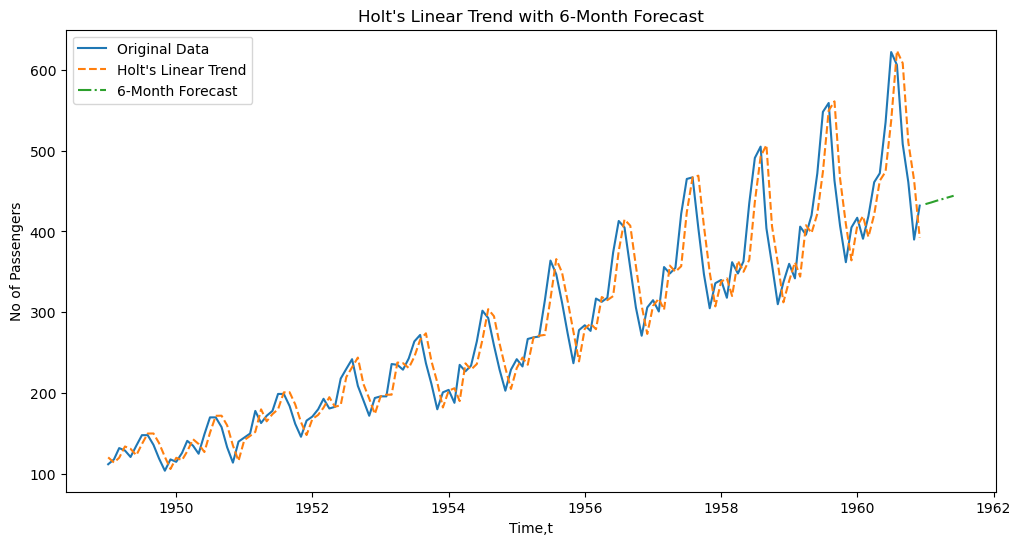

6-Month Forecast:
            Forecast
1961-01-01     434.0
1961-02-01     436.0
1961-03-01     438.0
1961-04-01     440.0
1961-05-01     442.0
1961-06-01     444.0


In [17]:
# Forecast 6 months ahead
forecast_steps = 6  # Number of months to forecast
forecast = holt_fit.forecast(forecast_steps)  # Forecasting 6 periods ahead

# Create forecast dates for the next 6 months
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]  # Skip the last known point

# Plot the original data, Holt's linear trend, and the 6-month forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['Holt_Trend'], label="Holt's Linear Trend", linestyle='--')
plt.plot(forecast_dates, forecast, label='6-Month Forecast', linestyle='-.')
plt.legend()
plt.title("Holt's Linear Trend with 6-Month Forecast")
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Ensure forecast is a pandas Series before rounding
forecast_series = pd.Series(forecast, index=forecast_dates)

# Create a DataFrame to list the forecasted values, with rounding
forecast_Holt = pd.DataFrame({'Forecast': forecast_series.round()})

# Output the 6-month forecast
print("6-Month Forecast:")
print(forecast_Holt)


## Holt-Winter Model

Optimal Alpha (smoothing level): 0.31854364546659575
Optimal Beta (smoothing slope): None
Optimal Gamma (smoothing seasonal): 0.601290956275535


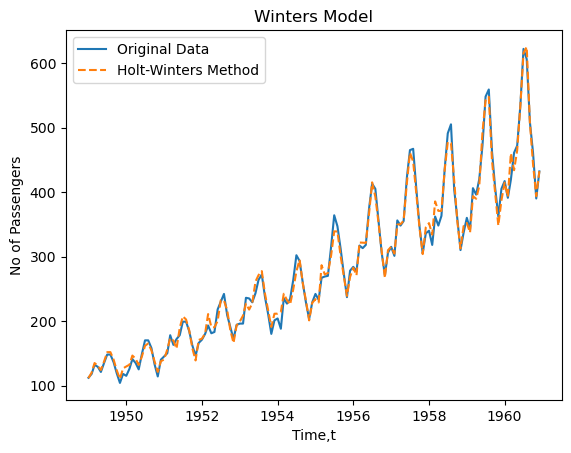

MAD for Holt-Winters: 7.9532
MAPE for Holt-Winters: 3.08%
MSE for Holt-Winters: 110.7839


In [18]:
# Create and fit the Holt-Winters model
holt_winters_model = ExponentialSmoothing(
    df['No of Passengers'], 
    trend='additive',
    seasonal='multiplicative',
    seasonal_periods=12  # Seasonal cycle (12 months)
)

holt_winters_fit = holt_winters_model.fit()  # Automatic optimization of smoothing levels

# Adding fitted values to DataFrame
df['Holt_Winters'] = holt_winters_fit.fittedvalues

# Retrieve the optimal smoothing parameters
optimal_alpha = holt_winters_fit.model.params.get('smoothing_level', None)  # Level smoothing
optimal_beta = holt_winters_fit.model.params.get('smoothing_slope', None)  # Trend smoothing
optimal_gamma = holt_winters_fit.model.params.get('smoothing_seasonal', None)  # Seasonal smoothing

print("Optimal Alpha (smoothing level):", optimal_alpha)
print("Optimal Beta (smoothing slope):", optimal_beta)
print("Optimal Gamma (smoothing seasonal):", optimal_gamma)

# Plotting original data and Holt-Winters method
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(df['Holt_Winters'], label="Holt-Winters Method", linestyle='--')
plt.title('Winters Model')
plt.legend()
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Performance metrics
# Calculate errors for Holt-Winters method
errors_holt_winters = df['No of Passengers'] - df['Holt_Winters']

# Calculate Mean Absolute Deviation (MAD)
MAD_Holt_Winters = np.mean(np.abs(errors_holt_winters))

# Calculate Mean Absolute Percentage Error (MAPE)
# Avoid division by zero with a condition
MAPE_Holt_Winters = np.mean(np.abs(errors_holt_winters) / df['No of Passengers']) * 100

# Calculate Mean Squared Error (MSE)
MSE_Holt_Winters = np.mean(errors_holt_winters ** 2)

print("MAD for Holt-Winters:", round(MAD_Holt_Winters, 4))
print("MAPE for Holt-Winters:", f"{round(MAPE_Holt_Winters, 2)}%")
print("MSE for Holt-Winters:", round(MSE_Holt_Winters, 4))


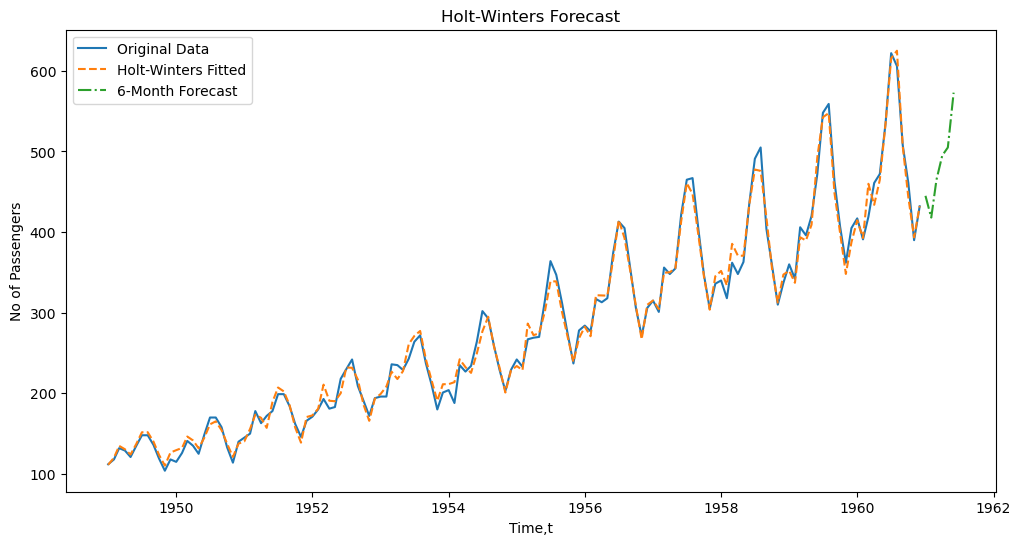

6-Month Forecast:
            Forecast
1961-01-01     445.0
1961-02-01     418.0
1961-03-01     465.0
1961-04-01     495.0
1961-05-01     505.0
1961-06-01     573.0


In [19]:
# Forecast 6 months ahead
forecast_steps = 6
forecast = holt_winters_fit.forecast(forecast_steps)

# Create forecast dates for the next 6 months
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]

# Ensure the forecast is a Series before applying round()
forecast_series = pd.Series(forecast, index=forecast_dates)

# Plot the original data, Holt-Winters fitted values, and the 6-month forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(holt_winters_fit.fittedvalues, label='Holt-Winters Fitted', linestyle='--')
plt.plot(forecast_series.index, forecast_series.round(), label='6-Month Forecast', linestyle='-.')
plt.legend()
plt.title("Holt-Winters Forecast")
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Create a DataFrame with forecasted values and round them
forecast_winter = pd.DataFrame({'Forecast': forecast_series.round()})
print("6-Month Forecast:")
print(forecast_winter)

## SARIMA

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(1,1,1)[12]             : AICC=1020.871, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AICC=1031.536, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AICC=1020.564, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AICC=1021.174, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AICC=1020.479, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AICC=1021.085, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AICC=1020.781, Time=0.24 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AICC=1022.565, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AICC=1022.565, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AICC=1020.724, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AICC=1018.135, Time=0.17 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AICC=1018.349, Time=0.29 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AICC=1018.794, Time=0.30 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AICC=1018.861, Time=0.60 sec
 ARI

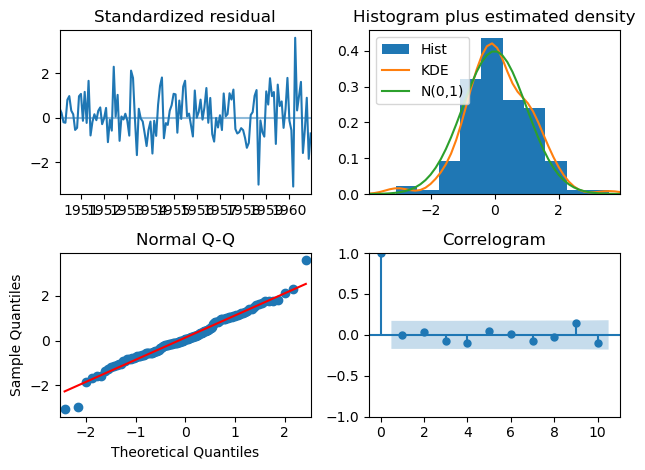

In [20]:
# Use auto.arima to find the best model
model = pm.auto_arima(
    df['No of Passengers'], 
    seasonal=True,  # True if there's a seasonal component
    m=12,  # Seasonal period (12 for monthly data with yearly seasonality)
    stepwise=True,  # Stepwise approach to finding the best model
    trace=True,  # Set to True to see the process in the console
    information_criterion='aicc'
)

# Print summary of the best model found
print(model.summary())

# Plot diagnostics to examine residuals
model.plot_diagnostics()
plt.tight_layout()
plt.show()

In [21]:
# Calculate fitted values (in-sample predictions)
fitted_values = model.predict_in_sample()

# Calculate errors (residuals)
errors_Sarima_auto = df['No of Passengers'] - fitted_values

# Calculate Mean Absolute Deviation (MAD)
MAD_Sarima_auto = np.mean(np.abs(errors_Sarima_auto))

# Calculate Mean Absolute Percentage Error (MAPE)
MAPE_Sarima_auto = np.mean(np.abs(errors_Sarima_auto) / df['No of Passengers']) * 100

# Calculate Mean Squared Error (MSE)
MSE_Sarima_auto = np.mean(errors_Sarima_auto ** 2)

print("MAD:", round(MAD_Sarima_auto, 4))
print("MAPE:", round(MAPE_Sarima_auto, 4))
print("MSE:", round(MSE_Sarima_auto, 4))

MAD: 9.8798
MAPE: 4.5081
MSE: 240.0415


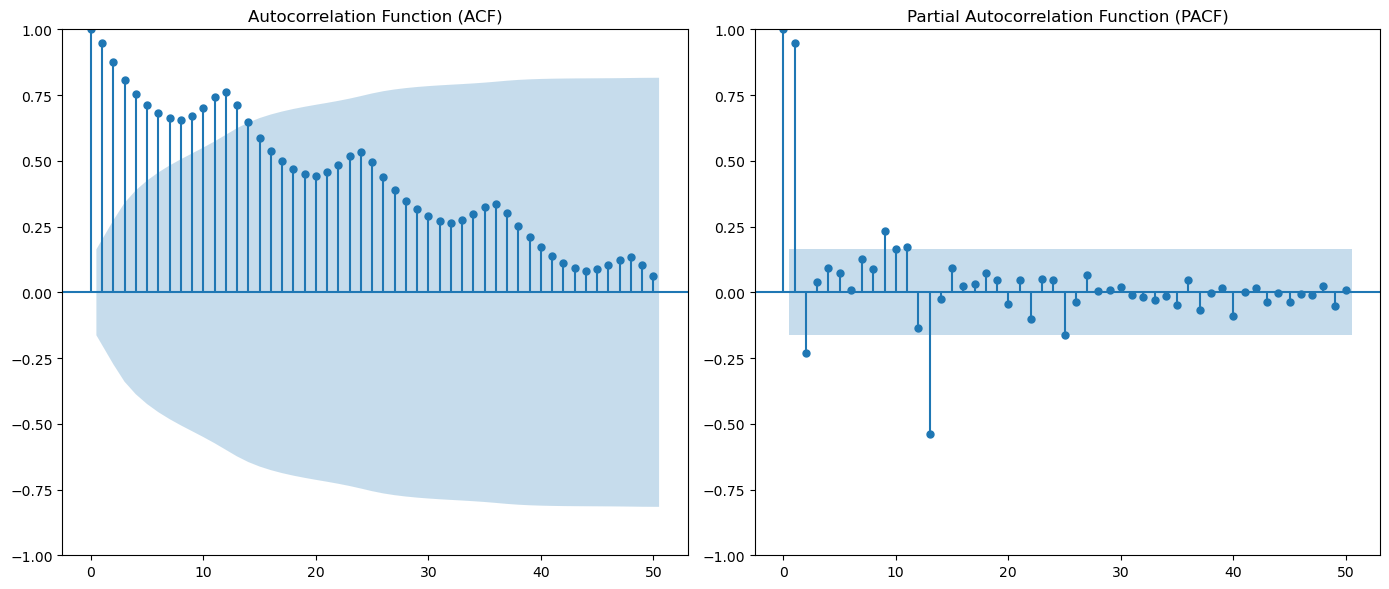

In [22]:
# Create a 1x2 subplot layout
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot ACF in the first subplot
plot_acf(df['No of Passengers'], lags=50, ax=ax[0])  # Use the specified axes
ax[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF in the second subplot with the recommended method
plot_pacf(df['No of Passengers'], lags=50, ax=ax[1], method='ywm')
ax[1].set_title("Partial Autocorrelation Function (PACF)")

# Adjust layout to avoid overlap
plt.tight_layout()  # Ensures no overlapping elements
plt.show()

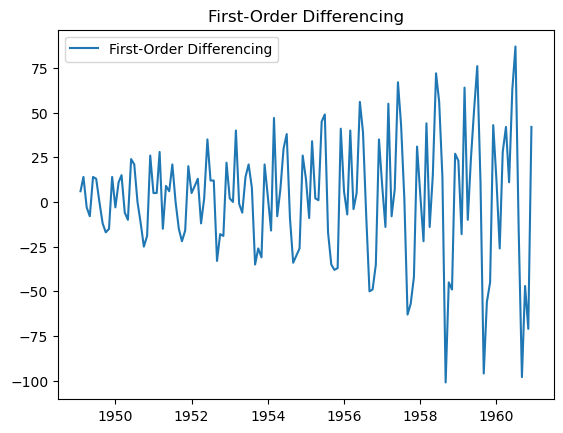

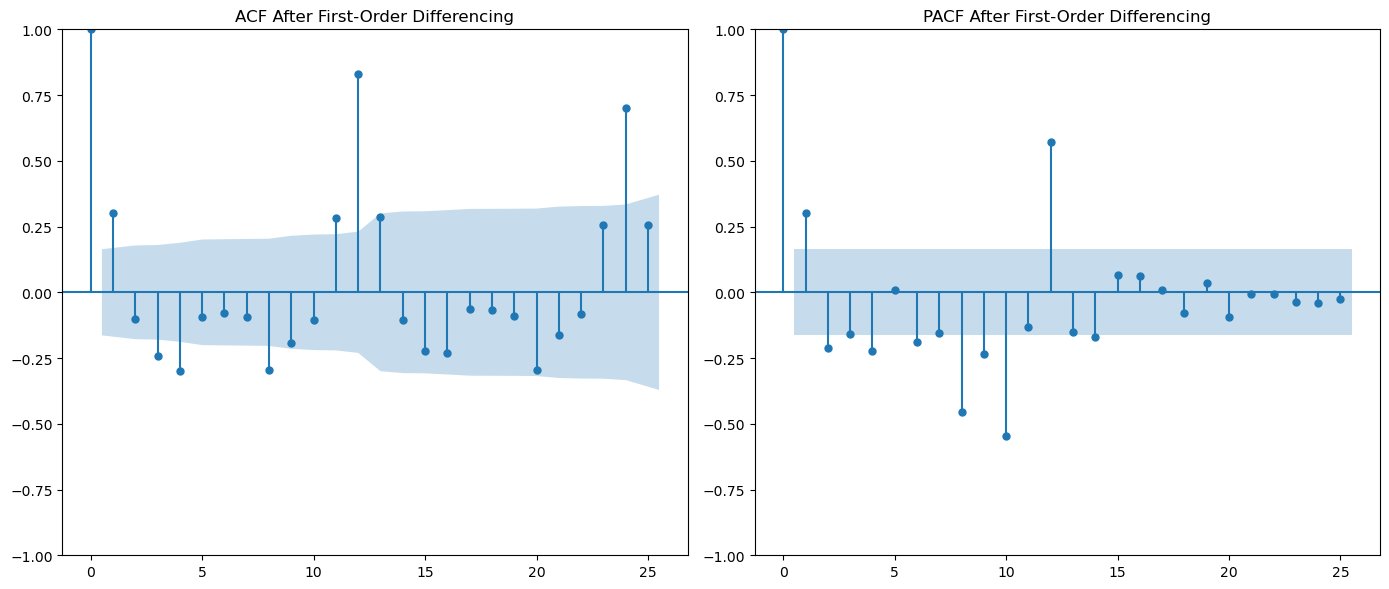

In [23]:
# Apply first-order differencing
df['First_Diff'] = df['No of Passengers'].diff()

# Plot the differenced series
plt.plot(df['First_Diff'], label='First-Order Differencing')
plt.title("First-Order Differencing")
plt.legend()
plt.show()

# Create a 1x2 subplot layout for ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot ACF for first-order differencing
plot_acf(df['First_Diff'].dropna(), lags=25, ax=ax[0])
ax[0].set_title("ACF After First-Order Differencing")

# Plot PACF for first-order differencing
plot_pacf(df['First_Diff'].dropna(), lags=25, ax=ax[1], method='ywm')  # Use the 'ywm' method
ax[1].set_title("PACF After First-Order Differencing")

plt.tight_layout()  # Adjust layout to avoid overlapping elements
plt.show()

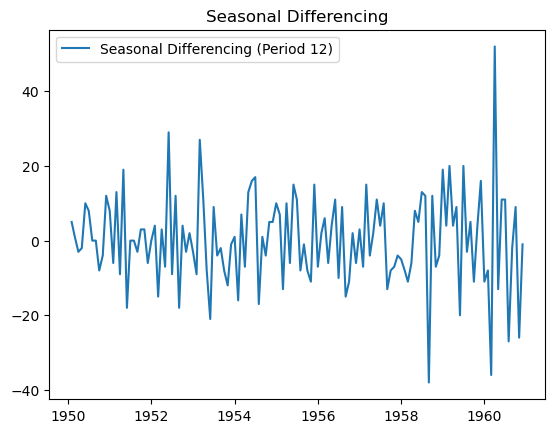

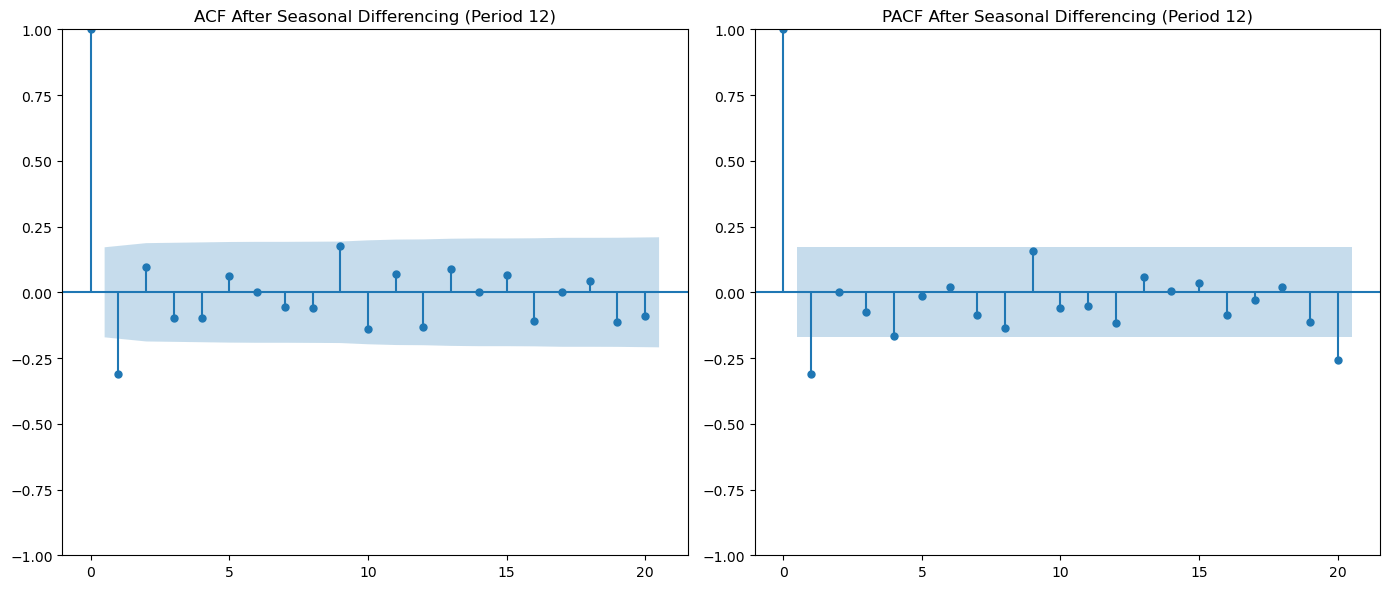

In [24]:
# Apply seasonal differencing with a period of 12
df['Seasonal_Diff'] = df['First_Diff'].diff(12)

# Plot the seasonally differenced series
plt.plot(df['Seasonal_Diff'], label='Seasonal Differencing (Period 12)')
plt.title("Seasonal Differencing")
plt.legend()
plt.show()

# Create a 1x2 subplot layout for ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot ACF for seasonal differencing
plot_acf(df['Seasonal_Diff'].dropna(), lags=20, ax=ax[0])
ax[0].set_title("ACF After Seasonal Differencing (Period 12)")

# Plot PACF for seasonal differencing
plot_pacf(df['Seasonal_Diff'].dropna(), lags=20, ax=ax[1], method='ywm')  # Use the 'ywm' method
ax[1].set_title("PACF After Seasonal Differencing (Period 12)")

plt.tight_layout()  # Adjust layout to avoid overlapping elements
plt.show()


In [25]:
# Perform the ADF test on the first-differenced series
adf_result = adfuller(df['Seasonal_Diff'].dropna())  # Drop NaN values due to differencing

# Extract the ADF statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]  # Get critical values for 1%, 5%, and 10% confidence levels

# Print the results of the ADF test
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

# Check if the series is stationary
significance_level = 0.05  # Common significance level for hypothesis testing
is_stationary = p_value < significance_level and adf_statistic < critical_values["5%"]

# Determine if the series is stationary based on the ADF test
if is_stationary:
    print("The first-order differenced series is stationary.")
else:
    print("The first-order differenced series is not stationary.")

ADF Statistic: -15.595618083746338
p-value: 1.856511600123444e-28
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
The first-order differenced series is stationary.


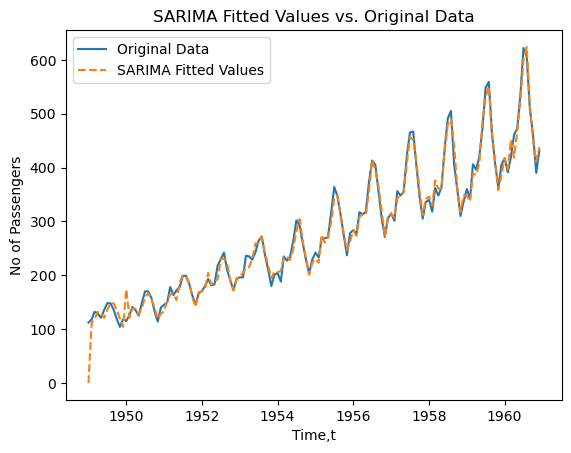

MAD: 9.7371
MAPE: 4.4419
MSE: 238.2037


In [26]:
# Fit SARIMA model
p, d, q = 2,1,2
P, D, Q, s = 0, 1, 1, 12
sarima_model = SARIMAX(df['No of Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, s))
fit_sarima = sarima_model.fit()

# Get the fitted values (in-sample predictions)
fitted_values = fit_sarima.fittedvalues

# Plot the original data and the fitted values
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(fitted_values, label='SARIMA Fitted Values', linestyle='--')  # Dashed line for distinction
plt.legend()
plt.title("SARIMA Fitted Values vs. Original Data")
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Perforamnce metrics
# Calculate errors (residuals)
errors_sarima = df['No of Passengers'] - fitted_values  # Residuals are the observed minus fitted values

# Calculate Mean Absolute Deviation (MAD)
MAD_Sarima_manual = np.mean(np.abs(errors_sarima))

# Calculate Mean Absolute Percentage Error (MAPE)
MAPE_Sarima_manual = np.mean(np.abs(errors_sarima) / df['No of Passengers']) * 100  # *100 to express as a percentage

# Calculate Mean Squared Error (MSE)
MSE_Sarima_manual = np.mean(errors_sarima ** 2)

print("MAD:", round(MAD_Sarima_manual, 4))
print("MAPE:", round(MAPE_Sarima_manual, 4))
print("MSE:", round(MSE_Sarima_manual, 4))


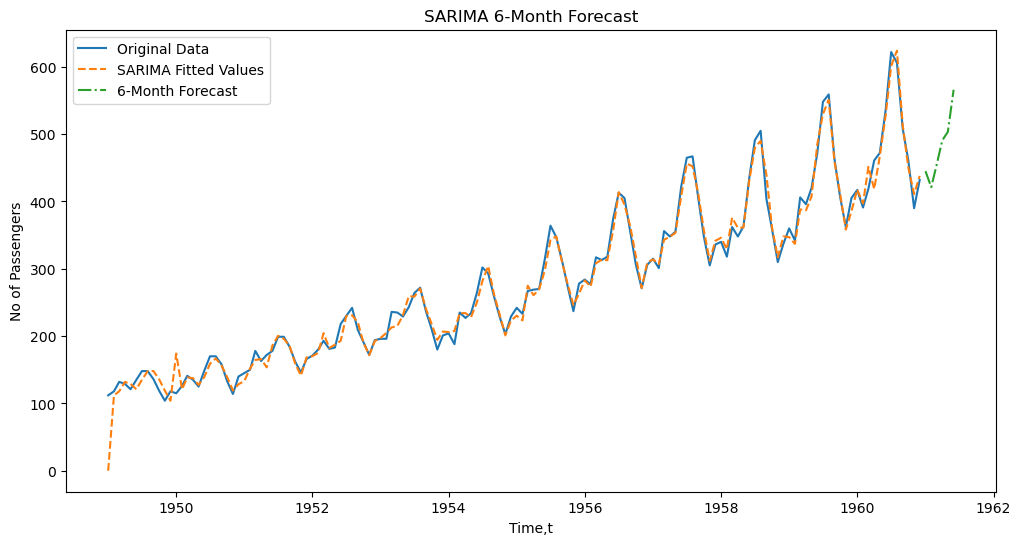

6-Month Forecast:
            Forecast
1961-01-01     445.0
1961-02-01     421.0
1961-03-01     453.0
1961-04-01     491.0
1961-05-01     503.0
1961-06-01     566.0


In [27]:
# Forecast 6 months ahead
forecast_steps = 6
forecast = fit_sarima.forecast(forecast_steps)

# Create forecast dates
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]  # Skip the last known point

# Plot the original data, SARIMA fitted values, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(fit_sarima.fittedvalues, label='SARIMA Fitted Values', linestyle='--')  # Dashed line
plt.plot(forecast_dates, forecast, label='6-Month Forecast', linestyle='-.')  # Dotted line
plt.legend()
plt.title("SARIMA 6-Month Forecast")
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Create a DataFrame to list the forecasted values
forecast_sarima = pd.DataFrame({'Forecast': forecast.round()})
print("6-Month Forecast:")
print(forecast_sarima)

## Performance Measure

In [28]:
# Create a DataFrame to organize the performance metrics
performance_table = pd.DataFrame({
    'Model': ['Moving Average', 'Simple Exponential Smoothing', "Holt's Model", "Winter's Model", 'SARIMA (AutoARIMA)', 'SARIMA (Manual)'],
    'MAD': [round(MAD_MA, 2), round(MAD_SES, 2), round(MAD_Holt, 2), round(MAD_Holt_Winters, 2), round(MAD_Sarima_auto, 2), round(MAD_Sarima_manual, 2)],
    'MAPE': [f"{round(MAPE_MA, 2)}%", f"{round(MAPE_SES, 2)}%", f"{round(MAPE_Holt, 2)}%", f"{round(MAPE_Holt_Winters, 2)}%", f"{round(MAPE_Sarima_auto, 2)}%", f"{round(MAPE_Sarima_manual, 2)}%"],
    'MSE': [round(MSE_MA, 2), round(MSE_SES, 2), round(MSE_Holt, 2), round(MSE_Holt_Winters, 2), round(MSE_Sarima_auto, 2), round(MSE_Sarima_manual, 2)]
})

performance_table


,Model,MAD,MAPE,MSE
0,Moving Average,40.04,12.39%,2995.16
1,Simple Exponential Smoothing,25.72,8.97%,1131.97
2,Holt's Model,25.60,9.0%,1127.60
3,Winter's Model,7.95,3.08%,110.78
4,SARIMA (AutoARIMA),9.88,4.51%,240.04
5,SARIMA (Manual),9.74,4.44%,238.20


## Best Model

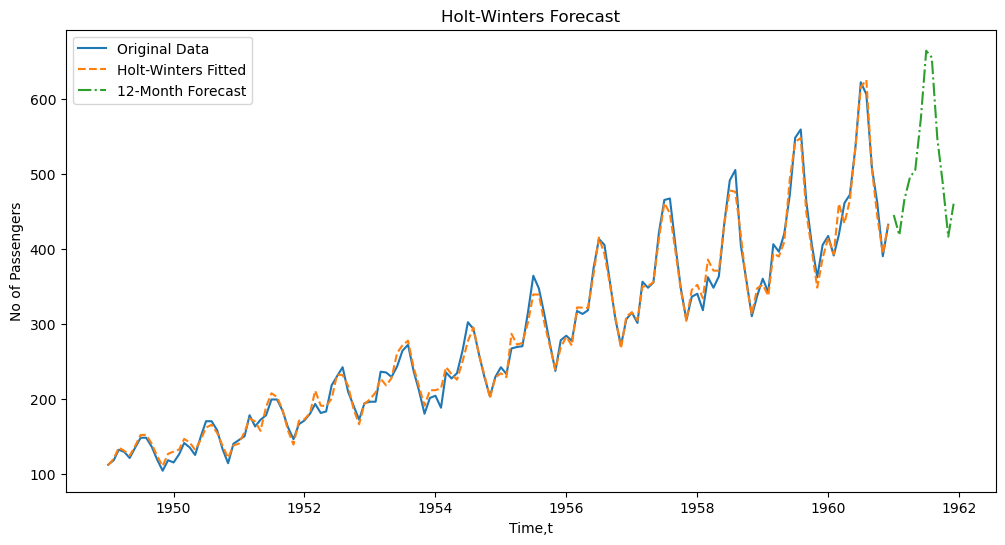

12-Month Forecast:
            Forecast
1961-01-01     445.0
1961-02-01     418.0
1961-03-01     465.0
1961-04-01     495.0
1961-05-01     505.0
1961-06-01     573.0
1961-07-01     664.0
1961-08-01     655.0
1961-09-01     547.0
1961-10-01     488.0
1961-11-01     416.0
1961-12-01     460.0


In [29]:
# Forecast 12 months ahead
forecast_steps = 12
forecast = holt_winters_fit.forecast(forecast_steps)

# Create forecast dates for the next 12 months
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]

# Ensure the forecast is a Series before applying round()
forecast_series = pd.Series(forecast, index=forecast_dates)

# Plot the original data, Holt-Winters fitted values, and the 12-month forecast
plt.figure(figsize=(12, 6))
plt.plot(df['No of Passengers'], label='Original Data')
plt.plot(holt_winters_fit.fittedvalues, label='Holt-Winters Fitted', linestyle='--')
plt.plot(forecast_series.index, forecast_series.round(), label='12-Month Forecast', linestyle='-.')
plt.legend()
plt.title("Holt-Winters Forecast")
plt.xlabel('Time,t')
plt.ylabel('No of Passengers')
plt.show()

# Create a DataFrame with forecasted values and round them
forecast_winter = pd.DataFrame({'Forecast': forecast_series.round()})
print("12-Month Forecast:")
print(forecast_winter)